In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/taxi-trip-fare-prediction/taxi_fare/submission.csv
/kaggle/input/taxi-trip-fare-prediction/taxi_fare/train.csv
/kaggle/input/taxi-trip-fare-prediction/taxi_fare/test.csv


In [2]:
train_df = pd.read_csv("/kaggle/input/taxi-trip-fare-prediction/taxi_fare/train.csv")
train_df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,748.0,2.75,1.0,75.00,24,6.300,105.300,0
1,1187.0,3.43,1.0,105.00,24,13.200,142.200,0
2,730.0,3.12,1.0,71.25,0,26.625,97.875,1
3,671.0,5.63,3.0,90.00,0,9.750,99.750,0
4,329.0,2.09,1.0,45.00,12,13.200,70.200,0


In [3]:
test_df = pd.read_csv("/kaggle/input/taxi-trip-fare-prediction/taxi_fare/test.csv")
test_df.head()

,trip_duration,distance_traveled,num_of_passengers,fare,tip,miscellaneous_fees,total_fare,surge_applied
0,1076.0,4.18,1.0,0,0,13.500,0,0
1,429.0,1.48,4.0,0,0,13.500,0,0
2,856.0,4.15,1.0,0,24,6.000,0,0
3,622.0,3.22,1.0,0,15,5.625,0,0
4,507.0,3.98,1.0,0,0,2.250,0,0


In [4]:
submissions_df = pd.read_csv("/kaggle/input/taxi-trip-fare-prediction/taxi_fare/submission.csv")
submissions_df.head()

,total_fare
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


* The `total_fare` column in the test_df is all 0, hence that data is only for the final prediction
* The `total_fare` column in the submissions_df is also full 0, hence that is just the output format. Both these datasets have 89860 rows

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209673 entries, 0 to 209672
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   trip_duration       209673 non-null  float64
 1   distance_traveled   209673 non-null  float64
 2   num_of_passengers   209673 non-null  float64
 3   fare                209673 non-null  float64
 4   tip                 209673 non-null  int64  
 5   miscellaneous_fees  209673 non-null  float64
 6   total_fare          209673 non-null  float64
 7   surge_applied       209673 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 12.8 MB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89861 entries, 0 to 89860
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   trip_duration       89861 non-null  float64
 1   distance_traveled   89861 non-null  float64
 2   num_of_passengers   89861 non-null  float64
 3   fare                89861 non-null  int64  
 4   tip                 89861 non-null  int64  
 5   miscellaneous_fees  89861 non-null  float64
 6   total_fare          89861 non-null  int64  
 7   surge_applied       89861 non-null  int64  
dtypes: float64(4), int64(4)
memory usage: 5.5 MB


In [7]:
#Function to show correlation matrix between all variables
def corr_matrix (df=None,method=None,show_values = True, return_flag = False):
    '''
    Function returns correlation of all variables with each other
    
    Parameters:
        df          : The dataframe with all variables
        method      : 'pearson','kendall','spearman'; Default is 'pearson'
        show_values : Boolean, Default True
    
    Returns:
        Correlation Matrix dataframe, if return_flag set to True. Returns nothing by default
    '''
    if method == None:
        method = 'pearson' 
    corr_name = method+'corr'
    df_corr = df.corr(method)
    plt.figure(figsize = (12,10))
    if show_values == True: sns.heatmap(df_corr,cmap = 'coolwarm',annot=True)
    else: sns.heatmap(df_corr,cmap = 'coolwarm')
    
    if return_flag == True: return df_corr
    else : return


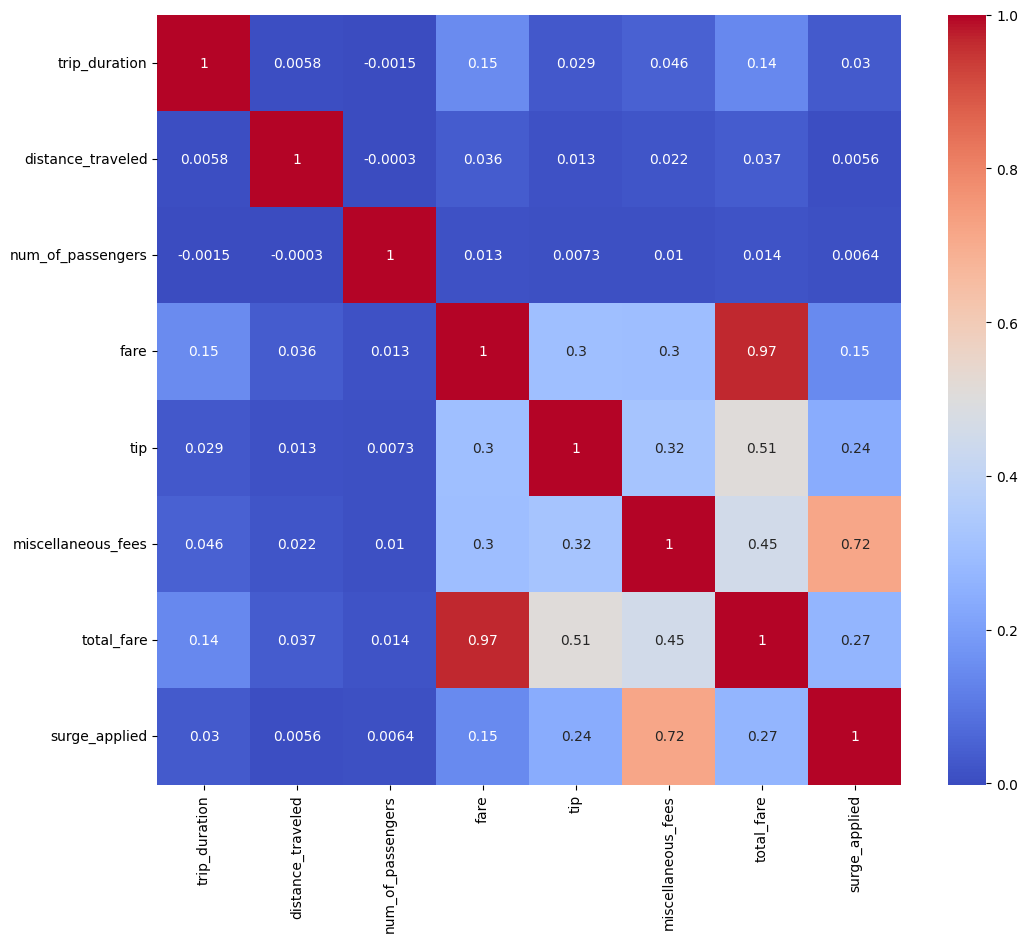

In [8]:
corr_matrix (train_df)

* `fare` and `total_fare` are highly correlated, and the guess if either of them have to be predicted, so choosing to drop `fare`
* `surge_applied` is also highly correlated with `miscellaeous_fees`, so will drop `surge_applied` as well
* Using the remianing features, I will model for `total_fare`

In [9]:
def show_distribution(df=None,variable_name='',
                      pctl = [1, 10, 20, 25, 30 , 33, 40 , 50 , 60 , 67, 70, 75, 80 , 90 , 99], 
                      plot= True, bins = 50,
                      decimals_ = 2):
    '''
    This function shows the distribution (Histogram plot) of any variable and returns some important percentile values of the variable
    Parameters:
        df            : The pandas dataframe that contains this variable data
        varaible_name : String, Name of the variable for which the distribution should be shown
        pctl          : List of Percentile values that should be returned (1 to 100 in multiples of 1)
        plot          : Boolean, Default True; Will plot a histogram if set to True
        bins          : The number of bins into which the data should be plotted on the histogram
        decimals_     : # of decimals shown for the varaible
    '''
    percentil = df[variable_name].quantile(np.linspace(.01, 1, 99, 0), 'lower')
    op = percentil.to_frame().reset_index()
    op.index = op.index+1.
    op = op[op.index.isin(pctl)]
    op.rename(columns = {'index': 'Percentile'},inplace=True)
    op.loc[len(op.index)] = [0, df[variable_name].min()]
    op.loc[len(op.index)] = [1, df[variable_name].max()]
    op['Percentile'] = 'p_'+ (op['Percentile']*100).astype(int).astype(str).str.zfill(2)
    op.loc[len(op.index)] = ['AVG', df[variable_name].mean()]
    op.sort_values(by=[variable_name,'Percentile'],inplace = True)
    op.reset_index(inplace=True,drop=True)
    op[variable_name] = op[variable_name].round(decimals_)
    if plot == True:
        plt.figure(figsize = (20,8))
        sns.histplot(x=df[variable_name], bins = bins, kde= True)
    return op

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,Percentile,total_fare
0,p_00,0.00
1,p_01,32.25
2,p_10,54.75
3,p_20,66.00
4,p_25,70.20
5,p_30,77.25
6,p_33,79.20
7,p_40,88.20
8,p_50,101.70
9,p_60,118.50


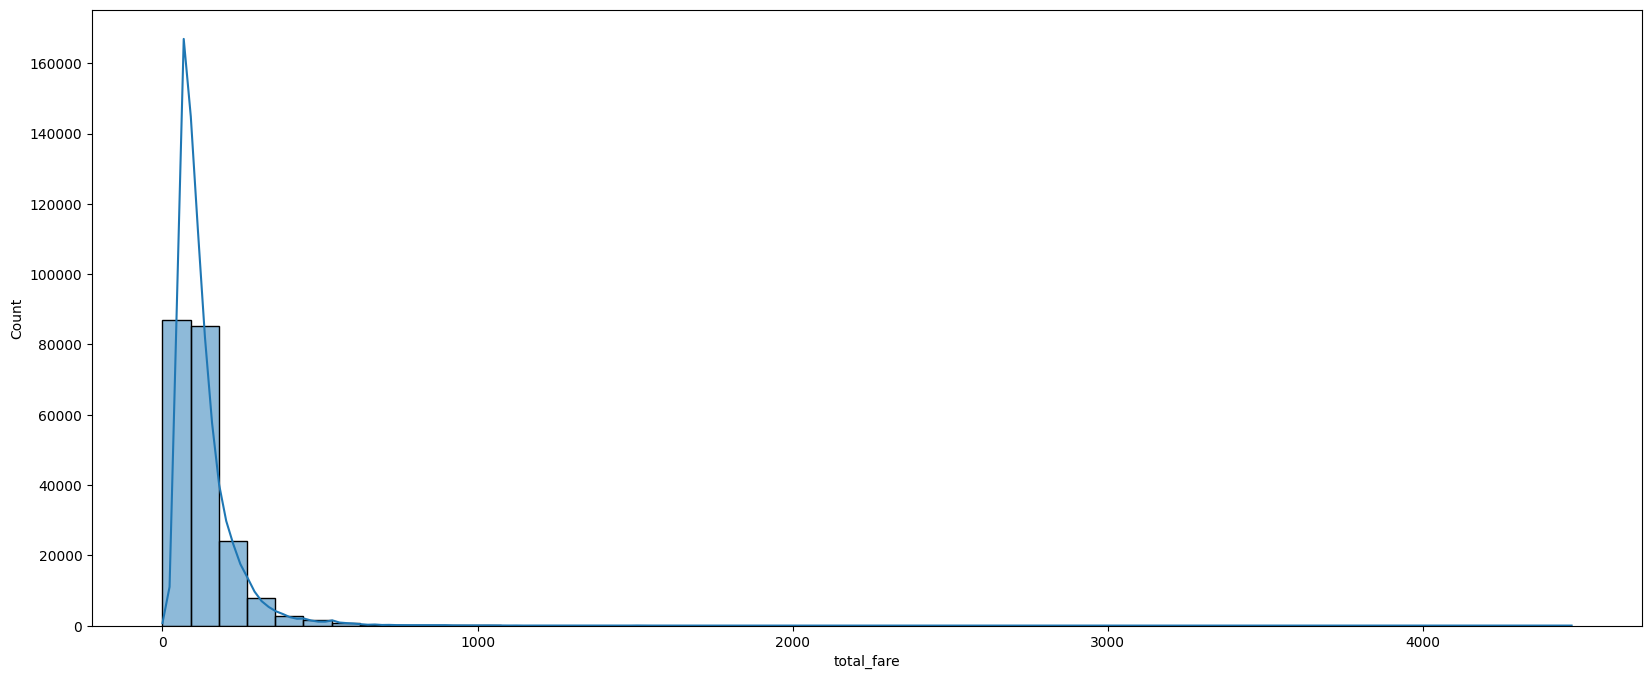

In [10]:
show_distribution(train_df,'total_fare')

In [11]:
#Since the distribution of the target-variable is right-skewed, we will use values between p01 and p99
train_df = train_df[(train_df['total_fare'] < train_df['total_fare'].quantile(.99))&(train_df['total_fare'] > train_df['total_fare'].quantile(.01))]

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,Percentile,total_fare
0,p_00,32.62
1,p_01,39.75
2,p_10,54.75
3,p_20,66.00
4,p_25,71.18
5,p_30,77.25
6,p_33,80.85
7,p_40,88.50
8,p_50,101.70
9,p_60,117.68


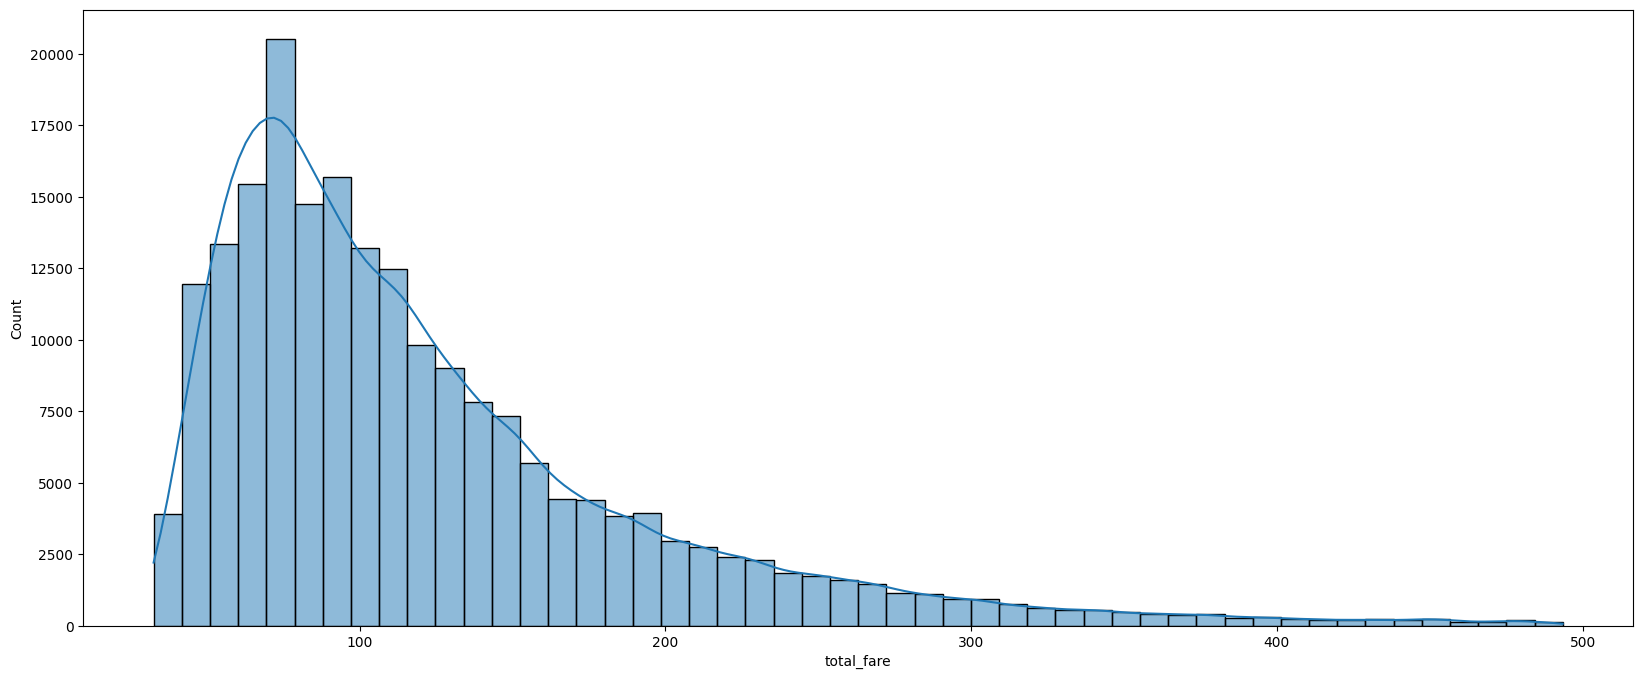

In [12]:
show_distribution(train_df,'total_fare')

# Model Build

In [13]:
#XGBoost Model
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_validate
import joblib
from sklearn.inspection import permutation_importance

from bayes_opt import BayesianOptimization

from time import time as ct

In [14]:
#Function to evaluate the regression model
from sklearn.metrics import mean_squared_error,mean_squared_log_error, mean_absolute_percentage_error, r2_score
def regression_eval(y_true,y_pred,thrs=0,predictors=0):
    '''
    This function evaluates the performance of a regression model and returns evaluation metrics
    
    Parameters:
        y_true (Numpy array) : The ground truth labels given in the dataset
        y_pred (Numpy array) : Our predictions
        thrs (numeric) : Threshold value for classifying as over-prediction/under-prediction
        predictors (int) : Number of predictors in our regression model
    
    Returns: Dataframe with below metrics to evaluate performance of the regression model
    	1. Number of Observations : Rows on which the model is being evaluated, length of the y_pred/y_true series
    	2. MAE : Mean Absolute Error
    	3. MAPE : Mean Absolute Percentage Error
    	4. RMSE : Root Mean Square Error
    	5. RMSLE : Root Mean Square Log Error
    	5. Coefficient of Determination - R2 : R Squared Value (Goodness of fit)
    	6. Adj. R2 : Adjusted R Squared Value (Takes into account number of predictors, observations, etc.)
    	7. Over-prediction Magnitude : Avg. Magnitude of over-prediction above a specified threshold
		8. Percentage of Over-prediction : %age Records where model over-predicts above a specified threshold compared to y_true
		9. Under-prediction Magnitude : Avg. Magnitude of under-prediction above a specified threshold
		10.Percentage of Under-prediction : %age Records where model under-predicts above a specified threshold compared to y_true
    
    '''
    if len(y_true) != len(y_pred):
        print('Length of Actual and Predicted lists is unequal. Please check and correct the same!')
        return
    
    eval_metrics = dict()
    n = len(y_true)
    k=predictors
    
    #Absolute magnitude of error: 
    all_err=np.abs(y_pred-y_true)
    mae=all_err.mean()
    overpred_magnitude=(all_err[y_pred-y_true>thrs]).mean()
    underpred_magnitude=(all_err[y_true-y_pred>thrs]).mean()
    
    max_overpred=(all_err[y_pred-y_true>thrs]).max()
    max_underpred=(all_err[y_true-y_pred>thrs]).max()
    
    #Percentage Error
    mape=np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    # mape = mean_absolute_percentage_error(y_true,y_pred) *100
    overpred_pct=(y_pred-y_true>thrs).mean() * 100
    underpred_pct=(y_true-y_pred>thrs).mean() * 100
    
    #RMSE & RMSLE
    rmse = np.sqrt(mean_squared_error(y_true,y_pred))
    #combinig the 2 series to find min and max to then calculate the RMSLE
    Y = pd.concat({"y_true": y_true,"y_pred": y_pred},axis=1)
    Y_min = Y.min().min()
    Y_max = Y.max().max()
    normalized_y_true = (y_true - Y_min) / (Y_max - Y_min)
    normalized_y_pred = (y_pred - Y_min) / (Y_max - Y_min)
    try:
        # rmsle = np.sqrt(mean_squared_log_error(normalized_y_true,normalized_y_pred))
        rmsle = np.sqrt(mean_squared_log_error(y_true,y_pred))
    except:
        print("An exception occurred while calculating rmsle.")
        rmsle = np.NaN
    
    #R2 and Adj. R2
    R2 = r2_score(y_true, y_pred)
    if k==0:
        print('Number of predictors has not been specified, hence Adjusted R2 will not be calculated')
        adj_R2 = np.NaN
    else: 
        adj_R2 = 1-((1-R2)*(n-1)/(n-k-1))
    
    #Combinig all metrics in dictionary and then to Dataframe
    eval_metrics['Length of Data'] = len(y_true)
    eval_metrics['MAE'] = mae
    eval_metrics['MAPE'] = mape
    eval_metrics['RMSE'] = rmse
    eval_metrics['RMSLE'] = rmsle
    eval_metrics['Coefficient of Determination - R2'] = R2
    eval_metrics['Adj. R2'] = adj_R2
    
    eval_metrics['Over-prediction Magnitude'] = overpred_magnitude
    eval_metrics['Percentage of Over-prediction'] = overpred_pct
    eval_metrics['Under-prediction Magnitude'] = underpred_magnitude
    eval_metrics['Percentage of Under-prediction'] = underpred_pct
    
    #Converting to Dataframe
    eval_metrics = pd.DataFrame([eval_metrics],columns=eval_metrics.keys()).T
    eval_metrics.columns = ['Value']
    eval_metrics.index.set_names('Evaluation Metric',inplace=True)
    eval_metrics['Value'] = eval_metrics['Value'].apply(lambda x: '%.2f' % x)
    
    #plotting the kde for actual and predicted values
    sns.kdeplot(y_true, label='Actual',  alpha=.75, fill = True)
    sns.kdeplot(y_pred, label='Predicted', alpha=.5, fill = True)
    # Plot formatting
    plt.legend(prop={'size': 10})
    plt.title('Regression Model Performance')
    plt.xlabel('Target Variable')
    plt.ylabel('Density')
    plt.figure(figsize = (20,8))
    
    return eval_metrics

#regression_eval(y_true,y_pred,thrs = 1, predictors=X.shape[1])

In [15]:
train_df.drop(['fare','surge_applied'],axis=1,inplace=True)
test_df.drop(['fare','surge_applied'],axis=1,inplace=True)

In [16]:
# X_train = train_df.drop('total_fare',axis=1)
# X_test = test_df.drop('total_fare',axis=1)
# y_train = train_df['total_fare']
# y_test = test_df['total_fare']

X = train_df.drop('total_fare',axis=1)
y= train_df['total_fare']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [17]:
#Standard Scaler Function [(x-mu)/sigma] - on Training Set
ss = StandardScaler()
ss.fit(X_train)

X_tr2=pd.DataFrame(ss.transform(X_train),columns=X_train.columns)

In [18]:
print(X_tr2.shape,y_train.shape)

(164112, 5) (164112,)


In [19]:
# Base Model
xgB=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=np.NaN, n_estimators=10,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=7272,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=7272,
             silent=None, subsample=1, verbosity=1)

xgB

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10,
             n_jobs=1, nthread=None, ...)

In [20]:
xgB.fit(X_tr2,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=5,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10,
             n_jobs=1, nthread=None, ...)

In [21]:
X_te2=pd.DataFrame(ss.transform(X_test),columns=X_test.columns)

In [22]:
y_actual = y_test
y_pred = pd.Series(xgB.predict(X_te2))

In [23]:
y_actual[:5]

128318     71.175
73659     452.475
41434     130.950
73026     265.950
121617    156.525
Name: total_fare, dtype: float64

In [24]:
y_pred[:5]

0     54.032928
1    185.845566
2     77.209061
3    149.510132
4     93.628899
dtype: float32

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,Value
Evaluation Metric,
Length of Data,41028.00
MAE,61.97
MAPE,47.75
RMSE,60.98
RMSLE,0.41
Coefficient of Determination - R2,0.32
Adj. R2,0.32
Over-prediction Magnitude,35.09
Percentage of Over-prediction,3.39


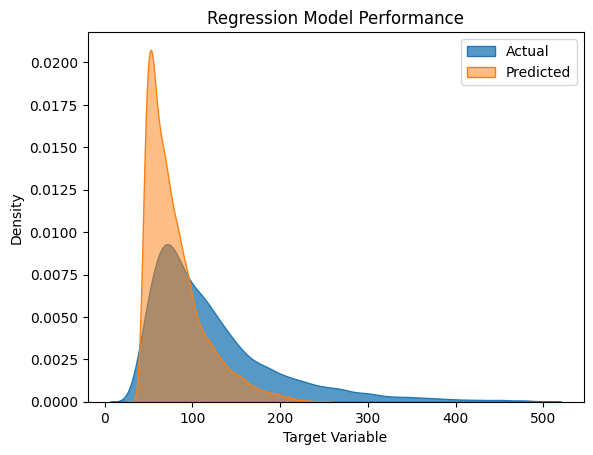

<Figure size 2000x800 with 0 Axes>

In [25]:
regression_eval(y_true=y_actual,y_pred=y_pred,predictors=5)

# # Finding Optimized Hyperparameters


In [26]:
# Target Function for optimizing hyperparams RMSE
def targ_func(y_true, y_pred):
    diff = np.sqrt(mean_squared_error(y_true,y_pred))
    return diff

target_fn = make_scorer(targ_func, greater_is_better=False)

In [27]:
#Evaluating the XGBoost model with different Hyperparams
def xgb_evaluate(max_depth,learning_rate,n_estimators,
                 gamma,reg_alpha,reg_lambda,X=X_train,y=y_train):
    '''
    Function that performs CV and we can use the results from the below optimization to decide on the best hyper parameters for the model
    '''

    md= int(max_depth)
    lr= max(learning_rate,0)
    ne= int(n_estimators)
    gamma= max(gamma, 0) # 0
    ra= max(reg_alpha, 0) # 0
    rl= max(reg_lambda, 0) # 1
    seed= 123

    xgb=XGBRegressor(objective='reg:squarederror',max_depth=md,learning_rate=lr,n_estimators=ne,gamma=gamma,reg_alpha=ra,reg_lambda=rl,seed=seed)
    cv_results = cross_validate(xgb, X, y, cv=5, scoring=target_fn)
    return cv_results['test_score'].mean()

In [28]:
xgbBO = BayesianOptimization(xgb_evaluate, {'max_depth': (6,12),'learning_rate': (0.3, 0.55),
                                            'n_estimators': (13,20),'gamma': (0.1, 2.5),'reg_alpha': (0.5, 2.6),
                                            'reg_lambda': (0.2, 1.2)})

In [29]:
st_time = ct()
xgbBO.maximize(init_points=10, n_iter=25)
print('Time for run : ~{:.0f} min'.format((ct()-st_time)/60))

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
| 1         | -15.14    | 0.5753    | 0.4012    | 8.619     | 19.74     | 2.243     | 0.729     |
| 2         | -15.3     | 1.196     | 0.4221    | 9.884     | 15.69     | 1.591     | 0.7268    |
| 3         | -15.54    | 2.466     | 0.3574    | 11.26     | 17.32     | 1.272     | 0.6285    |
| 4         | -15.59    | 0.7738    | 0.4928    | 6.285     | 18.14     | 1.099     | 0.6389    |
| 5         | -15.9     | 0.6224    | 0.4976    | 11.12     | 19.18     | 0.9143    | 0.8979    |
| 6         | -15.62    | 0.1945    | 0.4774    | 6.787     | 14.15     | 0.9101    | 0.6195    |
| 7         | -15.8     | 1.545     | 0.4823    | 10.32     | 13.31     | 1.362     | 0.4545    |
| 8         | -15.11    | 0.4985    | 0.4129    | 7.607     | 18.03     | 1.132     | 1.104     |
| 9         | -15.52

In [30]:
# Model using optimized values
gm_o = 2.5
lr_o = 0.3
md_o = 8
ne_o = 20
ra_o = 2.386
rl_o = 1.155

xgB_O=XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=gm_o,
             importance_type='gain', learning_rate=lr_o, max_delta_step=0,
             max_depth=md_o, min_child_weight=1, missing=np.NaN, n_estimators=ne_o,
             n_jobs=1, nthread=None, objective='reg:squarederror', random_state=7272,
             reg_alpha=ra_o, reg_lambda=rl_o, scale_pos_weight=1, seed=7272,
             silent=None, subsample=1, verbosity=1)

In [31]:
xgB_O.fit(X_tr2,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.3,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=2.5, grow_policy=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=0, max_depth=8,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=20,
             n_jobs=1, nthread=None, ...)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


,Value
Evaluation Metric,
Length of Data,41028.00
MAE,74.99
MAPE,74.55
RMSE,19.31
RMSLE,0.12
Coefficient of Determination - R2,0.93
Adj. R2,0.93
Over-prediction Magnitude,76.50
Percentage of Over-prediction,5.55


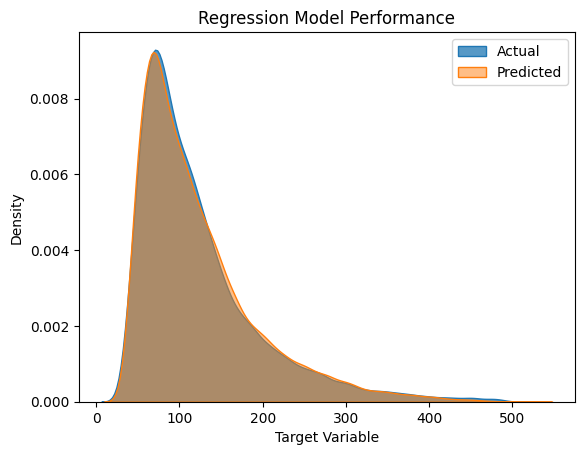

<Figure size 2000x800 with 0 Axes>

In [32]:
y_actual = y_test
y_pred = pd.Series(xgB_O.predict(X_te2))
regression_eval(y_true=y_actual,y_pred=y_pred,predictors=5)

In [33]:
# Simple Feature Importance
f_imp = pd.DataFrame({'Feature':X_tr2.columns,'Importance':xgB_O.feature_importances_}).sort_values(by = 'Importance')
# f_imp.tail(10).sort_values(by = 'Importance',ascending = False).reset_index()
f_imp.sort_values(by = 'Importance',ascending = False).reset_index()

,index,Feature,Importance
0,1,distance_traveled,0.727428
1,3,tip,0.111380
2,0,trip_duration,0.093319
3,4,miscellaneous_fees,0.044381
4,2,num_of_passengers,0.023492


<Axes: title={'center': 'Feature Importance'}, ylabel='Feature'>

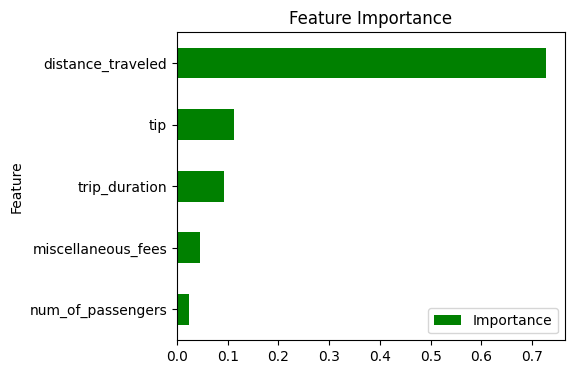

In [34]:
f_imp.tail(10).plot(kind='barh',title='Feature Importance',y='Importance',x='Feature',color='g',figsize=(5,4))

# # Predicting for the test data

In [35]:
test_df.head()

,trip_duration,distance_traveled,num_of_passengers,tip,miscellaneous_fees,total_fare
0,1076.0,4.18,1.0,0,13.500,0
1,429.0,1.48,4.0,0,13.500,0
2,856.0,4.15,1.0,24,6.000,0
3,622.0,3.22,1.0,15,5.625,0
4,507.0,3.98,1.0,0,2.250,0


In [36]:
test_df.drop('total_fare',axis=1,inplace=True)
X_test_final = pd.DataFrame(ss.transform(test_df),columns=test_df.columns)
y_pred_final = pd.Series(xgB_O.predict(X_test_final))

In [37]:
y_pred_final.shape

(89861,)

In [38]:
y_pred_final = y_pred_final.to_frame()
y_pred_final.columns = ['total_fare']
y_pred_final.head()

,total_fare
0,115.893837
1,63.600113
2,117.553169
3,96.693306
4,107.228233


In [39]:
# y_pred_final.to_csv("/kaggle/input/taxi-trip-fare-prediction/taxi_fare/submission.csv")
y_pred_final.to_csv("submission.csv")